In [1]:
import matplotlib.pyplot as plt
from typing import List, Dict
import numpy as np
import pandas as pd
import json
import os

In [2]:
DPI=100 # 300

In [3]:
root_directory = os.path.dirname("../")
logs_directory = os.path.join(root_directory, "logs")
logs_to_include = [] # Logs to include in the analysis
logs_to_include = [name for name in os.listdir(logs_directory) if os.path.isdir(os.path.join(logs_directory, name))]

## Goodput

In [4]:
def get_goodput_filesize_from_dir(directory: str) -> pd.DataFrame:
    """ Extracts goodput and filesize from the logs in a directory

    :param directory: The directory containing the logs
    :type directory: str
    :return: Returns a DataFrame with columns: filesize, goodput, implementation
    :rtype: pd.DataFrame
    """
    result_json = {}
    # Assuming logs_directory is defined elsewhere in your code
    with open(os.path.join(logs_directory, directory, "result.json")) as f:
        result_json = json.load(f)
    
    df = pd.DataFrame(columns=["filesize", "goodput", "implementation"])
    data_to_append = [] # Initialize an empty list to store data before appending
    
    for measurement in result_json["measurements"]:
        for measurement_entry in measurement:
            if measurement_entry["name"] == "goodput":
                goodput_runs = measurement_entry["details"]
                filesize = measurement_entry["filesize"]
                implementation = measurement_entry["implementation"]
                
                # Assuming goodput_runs is a list of goodput values
                for goodput in goodput_runs:
                    # Instead of appending directly to the DataFrame, store the data in a list
                    data_to_append.append({"filesize": filesize, "goodput": goodput, "implementation": implementation})
    
    # Use pd.concat to append the data from the list to the DataFrame
    df = pd.concat([df, pd.DataFrame(data_to_append)], ignore_index=True)
    return df

def get_goodput_filesize(directories: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(columns=["filesize", "goodput", "implementation"])
    for directory in directories:
        df_dir = get_goodput_filesize_from_dir(directory)
        df = pd.concat([df, df_dir], ignore_index=True)
    df["filesize"] = df["filesize"].astype(int)
    df["goodput"] = df["goodput"].astype(float)
    return df


In [5]:
goodput_df = get_goodput_filesize(logs_to_include)

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    
def generate_offset(width: float, number: int) -> List[float]:
    """Generated offsets"""
    if number == 2:
        return [-1 * width / 2, width / 2]
    raise NotImplemented("Implement it")
    # TODO generalize to more number and also odd number
    
def plot_goodput(ax: plt.Axes, df: pd.DataFrame):
    """ Plots the goodput data in a DataFrame. The expected DataFrame should have columns: filesize, goodput, implementation
    """
    df["filesize"] = df["filesize"] / (1024 * 1024 * 1024) # Convert to GB
    
    implementations = sorted(list(df["implementation"].unique()), reverse=True)
    filesizes = list(df["filesize"].unique())
    filesizes.sort()
    filesizes = np.array(filesizes)
    colors = ["blue", "red", "green", "orange"]
    next_index = 0
    max_observed = 0
    box_width = 0.4
    offsets = generate_offset(box_width, len(implementations))
    
    for implementation in implementations:
        df_impl = df[df["implementation"] == implementation]
        subboxplot_data = []
        for filesize in filesizes:
            goodput_values = df_impl[df_impl["filesize"] == filesize]["goodput"]
            goodput_values = goodput_values.to_numpy()
            subboxplot_data.append(goodput_values)
            max_observed = max(max_observed, max(goodput_values))
        bxp = ax.boxplot(subboxplot_data, positions=filesizes + offsets[next_index], widths=box_width, showfliers=False)
        set_box_color(bxp, colors[next_index])
        next_index += 1
    
    ax.set_xticks(filesizes, filesizes)
    ax.set_xlabel("Transfer Size [GB]")
    ax.set_ylabel("Goodput [Mbps]")
    ax.grid(which='major', color='black', linewidth=1, alpha=0.3, linestyle="dashed") # Show the major grid
    ax.grid(which='minor', axis="y", color='black', linewidth=0.6, alpha=0.3, linestyle="dotted") # Show the major grid
    ax.set_ylim(0, max_observed * 1.02)
    
    for i in range(next_index):
        ax.plot([], c=colors[i], label=implementations[i])
    ax.legend()    
    ax.minorticks_on() # Make the minor ticks and gridlines show

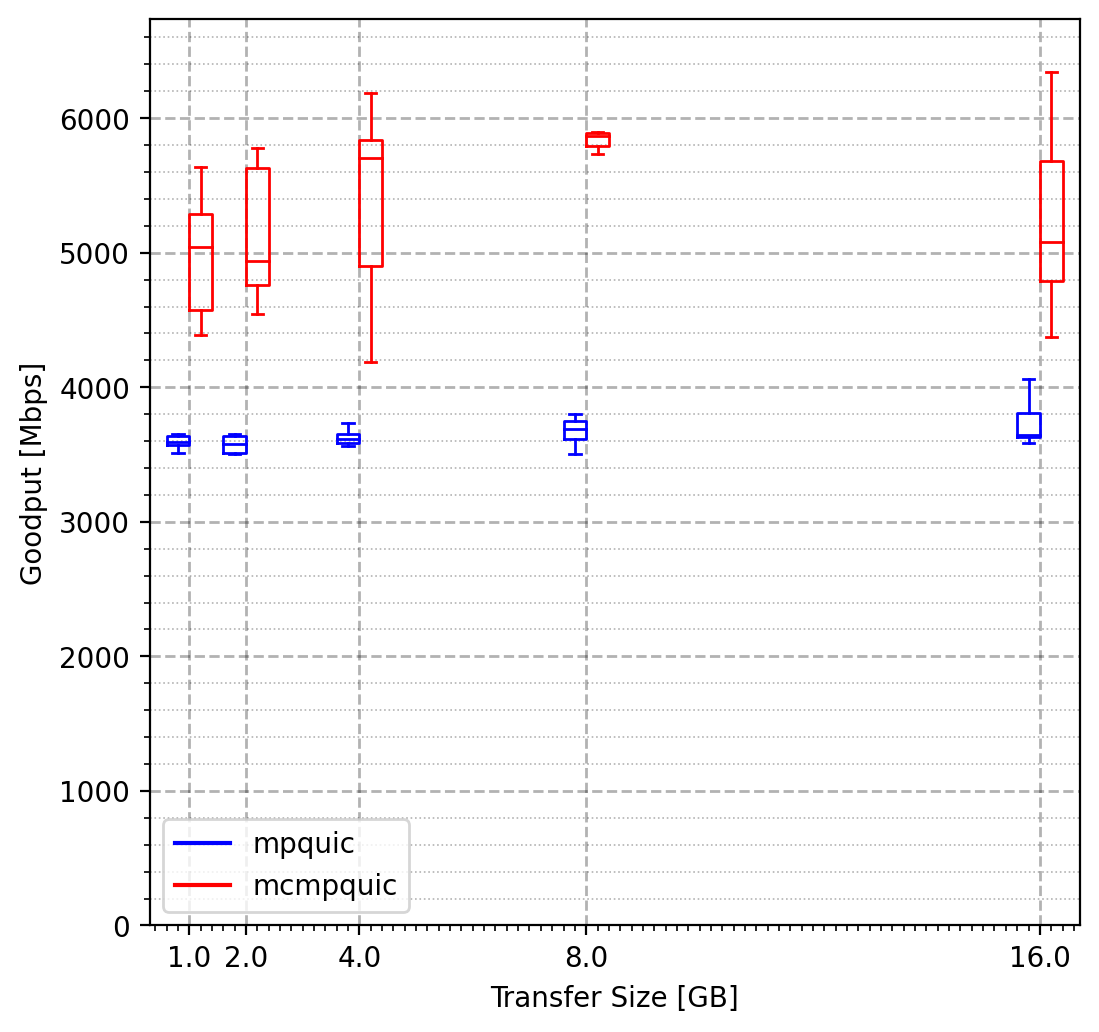

In [7]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=200)
plot_goodput(ax, goodput_df.copy())
plt.show()